<a href="https://colab.research.google.com/github/skywalker0803r/baseball_ProofofConcept/blob/main/%E7%90%83%E7%A8%AE%E5%88%86%E9%A1%9E%E7%AF%84%E4%BE%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 資料載入和初步探索
這裡發生了什麼事？
程式碼的初始部分用於載入原始軌跡資料和相關元資料（音高類型和描述）。您正在遍歷特定的播放器目錄，讀取包含軌跡、音調類型和每個記錄音調的描述的 pickle 檔案。

您也執行了一個重要步驟：確定已過濾軌跡的 max_len。這有助於理解時間序列資料的不同長度，從而影響後續的特徵提取。這裡應用了 traj_vec_filter 函數來了解清理後的軌跡長度。

為什麼這很重要？
在建立任何模型之前，您需要將資料放入記憶體中。此步驟確保所有單獨的音高軌跡及其標籤都已載入並準備好進行處理。了解軌跡的最大長度也有助於設計可以處理可變長度序列的特徵。

In [38]:
import os
import pickle
import time
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler

# --- Your existing traj_vec_filter and extract_features functions would go here ---
# (I'm omitting them for brevity in this explanation, but they are part of your script)

def traj_vec_filter(traj_vec, aspect_ratio_threshold=0.33):
    """
    過濾不合理的軌跡框（非棒球的偵測框）。
    """
    filtered = []
    for box in traj_vec:
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        if w <= 0 or h <= 0:
            continue
        aspect_ratio = w / h
        if (1 - aspect_ratio_threshold) <= aspect_ratio <= (1 + aspect_ratio_threshold):
            filtered.append(box)
    return filtered

def extract_features(traj_vec, keyframe_count=5):
    """
    Extracts a hybrid of statistical and keyframe features from a trajectory.
    """
    if not traj_vec:
        # Return a zero-vector of the correct dimension
        return np.zeros(28 + (keyframe_count * 3 * 4))

    # 1. Statistical Features (as before)
    boxes = np.array(traj_vec)
    widths = (boxes[:, 2] - boxes[:, 0]).reshape(-1, 1)
    heights = (boxes[:, 3] - boxes[:, 1]).reshape(-1, 1)
    areas = (widths * heights).reshape(-1, 1)
    center_x = ((boxes[:, 0] + boxes[:, 2]) / 2).reshape(-1, 1)
    center_y = ((boxes[:, 1] + boxes[:, 3]) / 2).reshape(-1, 1)

    delta_x = np.diff(center_x, axis=0) if len(center_x) > 1 else np.array([[0]])
    delta_y = np.diff(center_y, axis=0) if len(center_y) > 1 else np.array([[0]])

    velocity_x = delta_x
    velocity_y = delta_y
    speed = np.sqrt(velocity_x**2 + velocity_y**2)

    accel_x = np.diff(velocity_x, axis=0) if len(velocity_x) > 1 else np.array([[0]])
    accel_y = np.diff(velocity_y, axis=0) if len(velocity_y) > 1 else np.array([[0]])
    acceleration = np.sqrt(accel_x**2 + accel_y**2)

    statistical_features = [
        center_x[0, 0], center_y[0, 0], center_x[-1, 0], center_y[-1, 0],
        np.sum(np.abs(delta_x)), np.sum(np.abs(delta_y)),
        np.mean(widths), np.std(widths), np.mean(heights), np.std(heights),
        np.mean(areas), np.std(areas), np.mean(speed), np.std(speed),
        np.max(speed), np.min(speed), np.mean(velocity_x), np.std(velocity_x),
        np.mean(velocity_y), np.std(velocity_y), np.mean(acceleration),
        np.std(acceleration), np.max(acceleration), np.mean(accel_x),
        np.std(accel_x), np.mean(accel_y), np.std(accel_y), len(traj_vec)
    ]

    # 2. Keyframe Features
    keyframe_features = []

    # Normalize trajectory to a fixed number of points using interpolation
    if len(traj_vec) > 1:
        # Original indices (0 to len-1)
        original_indices = np.linspace(0, len(traj_vec) - 1, num=len(traj_vec))
        # New indices for interpolation
        target_indices = np.linspace(0, len(traj_vec) - 1, num=keyframe_count * 3)

        # Interpolate each column of the boxes array
        interpolated_boxes = np.zeros((keyframe_count * 3, 4))
        for i in range(4):
            interpolated_boxes[:, i] = np.interp(target_indices, original_indices, boxes[:, i])

        # Split into start, middle, end sections
        start_frames = interpolated_boxes[:keyframe_count]
        middle_frames = interpolated_boxes[keyframe_count : 2 * keyframe_count]
        end_frames = interpolated_boxes[2 * keyframe_count : 3 * keyframe_count]
    else: # Handle very short trajectories
        single_frame = boxes[0] if len(boxes) > 0 else np.zeros(4)
        start_frames = np.tile(single_frame, (keyframe_count, 1))
        middle_frames = np.tile(single_frame, (keyframe_count, 1))
        end_frames = np.tile(single_frame, (keyframe_count, 1))

    # Flatten keyframe data (x, y, w, h)
    for frame_set in [start_frames, middle_frames, end_frames]:
        for box in frame_set:
            w = box[2] - box[0]
            h = box[3] - box[1]
            keyframe_features.extend([box[0], box[1], w, h])

    # 3. Combine Features
    return np.array(statistical_features + keyframe_features)


X_data = []
y1_data = []
y2_data = []
max_len = 0
player_name_list = [
    'Shohei_Ohtani_SL','Shohei_Ohtani_FS','Shohei_Ohtani_FF',
    'Gerrit_Cole_CH','Gerrit_Cole_FF','Gerrit_Cole_SL',
    'Yu_Darvish_FF','Yu_Darvish_FS','Yu_Darvish_SL',
]

for player_name in tqdm(player_name_list, desc="Loading Player Data"):
    folder = f'/content/drive/MyDrive/Baseball Movies/{player_name}_videos_4S/baseball_trajectory_bbox_with_pitch_type_description'
    if not os.path.exists(folder):
        continue
    for fname in os.listdir(folder):
        if not fname.endswith('.pkl'):
            continue
        with open(os.path.join(folder, fname), 'rb') as f:
            data = pickle.load(f)
        traj = data['trajectory']
        traj_vec_raw_for_maxlen = [list(t[1:]) if t[1] is not None else [0,0,0,0] for t in traj]
        traj_vec_filtered_for_maxlen = traj_vec_filter(traj_vec_raw_for_maxlen)
        max_len = max(max_len, len(traj_vec_filtered_for_maxlen))
        X_data.append(traj)
        y1_data.append(data['pitch_type'])
        y2_data.append(data['description'])

print(f"Total trajectories loaded: {len(X_data)}")
print(f"Maximum filtered trajectory length: {max_len}")
print(f"Example pitch types: {y1_data[:5]}")
print(f"Example descriptions: {y2_data[:5]}")

Loading Player Data: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]

Total trajectories loaded: 1297
Maximum filtered trajectory length: 221
Example pitch types: ['ST', 'ST', 'ST', 'ST', 'ST']
Example descriptions: ['swinging_strike', 'swinging_strike', 'ball', 'ball', 'foul']


/tmp/ipython-input-39-4333228.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', len(unique_descriptions))


Saving GIF to /tmp/trajectories.gif...
GIF saved!


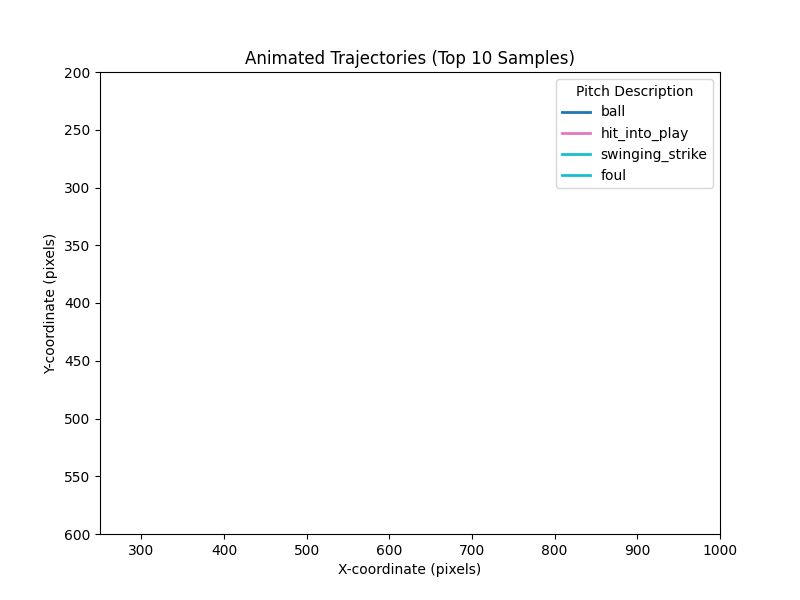

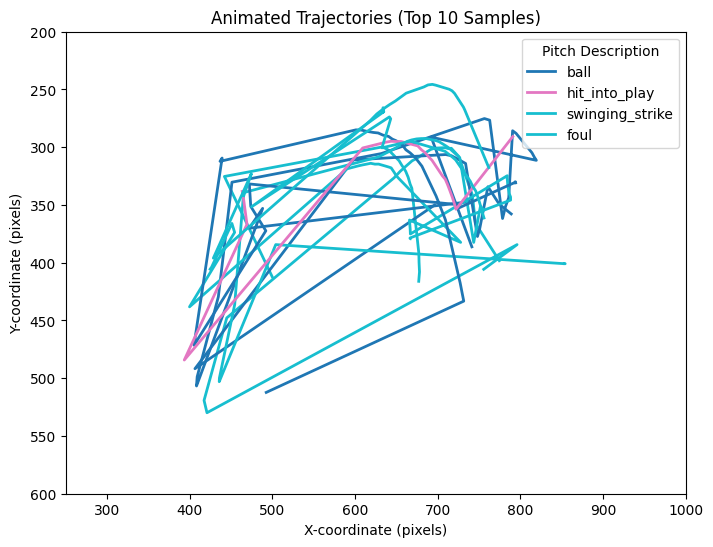

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display
import os

# Create a dummy log_step function to avoid NameError if not defined elsewhere
def log_step(message):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# Establish description to color mapping
unique_descriptions = list(set(y2_data))
color_map = cm.get_cmap('tab10', len(unique_descriptions))
description_to_color = {desc: color_map(i) for i, desc in enumerate(unique_descriptions)}

# Process the first 10 trajectories for visualization
max_trajectories = min(10, len(X_data))
trajectories_for_viz = [] # Renamed to avoid conflict with local variable in your original code

# Find the max_len for the visualization subset specifically
viz_max_len = 0
for idx in range(max_trajectories):
    traj = X_data[idx]
    description = y2_data[idx]
    traj_vec = [list(t[1:]) for t in traj if t[1] is not None]
    traj_vec = traj_vec_filter(traj_vec)

    if len(traj_vec) == 0:
        continue

    cx_list = [(x1 + x2) / 2 for x1, y1, x2, y2 in traj_vec]
    cy_list = [(y1 + y2) / 2 for x1, y1, x2, y2 in traj_vec]

    trajectories_for_viz.append({
        'cx': cx_list,
        'cy': cy_list,
        'color': description_to_color[description],
        'label': description
    })

    viz_max_len = max(viz_max_len, len(cx_list))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(250, 1000) # Assuming these are reasonable limits for your data
ax.set_ylim(600, 200)  # Invert y-axis to match image coordinates (origin at top-left)
ax.set_title('Animated Trajectories (Top 10 Samples)')
ax.set_xlabel('X-coordinate (pixels)')
ax.set_ylabel('Y-coordinate (pixels)')

lines = []
# Initialize each line for the animation
for traj in trajectories_for_viz:
    line, = ax.plot([], [], color=traj['color'], label=traj['label'], linewidth=2)
    lines.append(line)

# Create a legend to show the description-color mapping
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(ul)] for ul in unique_labels]
ax.legend(unique_handles, unique_labels, loc='upper right', title="Pitch Description")


# Update function for the animation
def update(frame):
    current_lines = []
    for i, traj in enumerate(trajectories_for_viz):
        cx = traj['cx'][:frame]
        cy = traj['cy'][:frame]
        lines[i].set_data(cx, cy)
        current_lines.append(lines[i])
    return current_lines

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=viz_max_len, interval=50, blit=True, repeat=False)

# Save as GIF
gif_path = "/tmp/trajectories.gif"
print(f"Saving GIF to {gif_path}...")
ani.save(gif_path, writer='pillow', fps=20)
print("GIF saved!")

# Display GIF
display(Image(filename=gif_path))

[2025-07-09 12:49:35] Starting hybrid (statistical + keyframe) feature extraction...


Preprocessing Trajectories: 100%|██████████| 1297/1297 [00:00<00:00, 1396.27it/s]


[2025-07-09 12:49:36] Finished hybrid feature extraction.

Shape of extracted features (X_features): (1297, 88)
First 5 feature vectors (first 10 components):
[[755.71276855 405.71502686 774.59692383 398.22543335 776.18591309
  494.88235474  19.36366463   1.46584928  19.29714394   2.11288333]
 [499.88165283 412.17785645 677.11175537 416.09234619 294.77734375
  228.6317749   20.09373474   1.40997493  20.47036362   1.90966785]
 [735.14105225 345.15429688 741.38024902 386.24255371 951.69073486
  730.76983643  21.44674492   3.40324807  19.85809135   2.66897106]
 [696.51196289 350.27618408 789.00708008 357.76693726 672.73474121
  465.20315552  19.26512718   1.27283418  18.22501945   1.44700849]
 [424.81872559 405.54992676 666.94128418 379.15637207 718.79138184
  441.00036621  19.21000862   2.34686422  18.75032234   1.86624789]]

Distribution of Pitch Types:
- ST: 156
- FS: 312
- FF: 429
- CH: 28
- SL: 372

Distribution of Descriptions:
- swinging_strike: 180
- ball: 416
- foul: 234
- hit_in

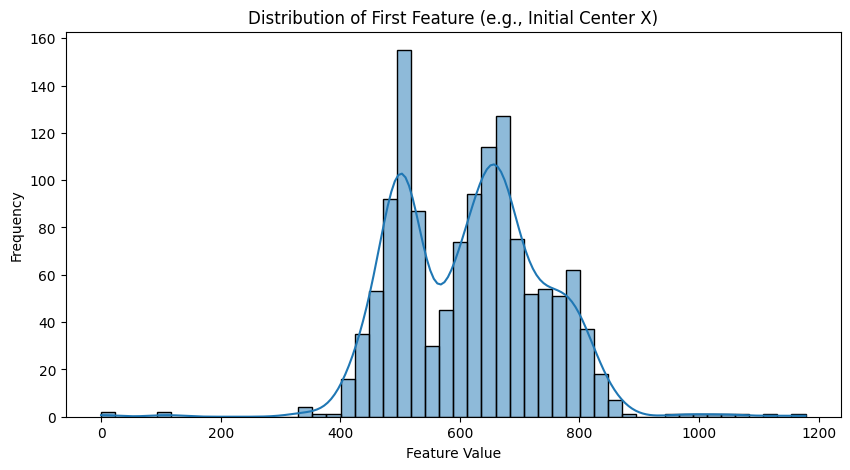

In [40]:
# Assuming traj_vec_filter and extract_features are already defined as in your initial code.
# The TrajectoryPreprocessor class is also defined in your script.

class TrajectoryPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, keyframe_count=5):
        self.keyframe_count = keyframe_count

    def fit(self, X, y=None):
        return self

    def transform(self, X_raw):
        log_step("Starting hybrid (statistical + keyframe) feature extraction...")
        out_features = []
        for traj in tqdm(X_raw, desc="Preprocessing Trajectories"):
            # Ensure traj_vec_raw handles None values as empty lists or a placeholder
            traj_vec_raw = [list(t[1:]) for t in traj if t[1] is not None]
            traj_vec_filtered = traj_vec_filter(traj_vec_raw)
            features = extract_features(traj_vec_filtered, self.keyframe_count)
            out_features.append(features)
        log_step("Finished hybrid feature extraction.")
        # Replace NaNs and Infs with 0, a simple but robust imputation
        return np.nan_to_num(np.array(out_features), nan=0.0, posinf=0.0, neginf=0.0)

# Instantiate the preprocessor
preprocessor = TrajectoryPreprocessor(keyframe_count=5)

# Transform the raw data into features
# This will apply the filter and feature extraction
X_features = preprocessor.transform(X_data)

print(f"\nShape of extracted features (X_features): {X_features.shape}")
print(f"First 5 feature vectors (first 10 components):\n{X_features[:5, :10]}")

# You can also look at the distribution of your labels
pitch_type_counts = Counter(y1_data)
description_counts = Counter(y2_data)

print("\nDistribution of Pitch Types:")
for pitch_type, count in pitch_type_counts.items():
    print(f"- {pitch_type}: {count}")

print("\nDistribution of Descriptions:")
for desc, count in description_counts.items():
    print(f"- {desc}: {count}")

# Visualize feature distribution (example for one feature, e.g., first feature)
plt.figure(figsize=(10, 5))
sns.histplot(X_features[:, 0], bins=50, kde=True)
plt.title('Distribution of First Feature (e.g., Initial Center X)')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.show()

# You might want to visualize the correlation matrix of features if you have many
# For a quick check of feature consistency, a histogram is good.


Encoded Pitch Types (first 5): [4 4 4 4 4]
Pitch Type Classes: ['CH' 'FF' 'FS' 'SL' 'ST']
Encoded Descriptions (first 5): [9 9 0 0 3]
Description Classes: ['ball' 'blocked_ball' 'called_strike' 'foul' 'foul_bunt' 'foul_tip'
 'hit_by_pitch' 'hit_into_play' 'missed_bunt' 'swinging_strike'
 'swinging_strike_blocked']
[2025-07-09 12:49:37] Splitting data into training and testing sets...
[2025-07-09 12:49:37] Data split complete.
X_train shape: (1037, 88)
y_train shape: (1037,)
X_test shape: (260, 88)
y_test shape: (260,)

Class distribution in y_train before oversampling:
FS: 250
SL: 297
ST: 125
FF: 343
CH: 22
[2025-07-09 12:49:37] Building and training the Random Forest Classifier pipeline with RandomOverSampler...
[2025-07-09 12:49:38] Model training complete.
[2025-07-09 12:49:38] Making predictions on the test set...
[2025-07-09 12:49:38] Predictions complete.

Model Evaluation Results:

Accuracy: 0.5885

Classification Report:
              precision    recall  f1-score   support

 

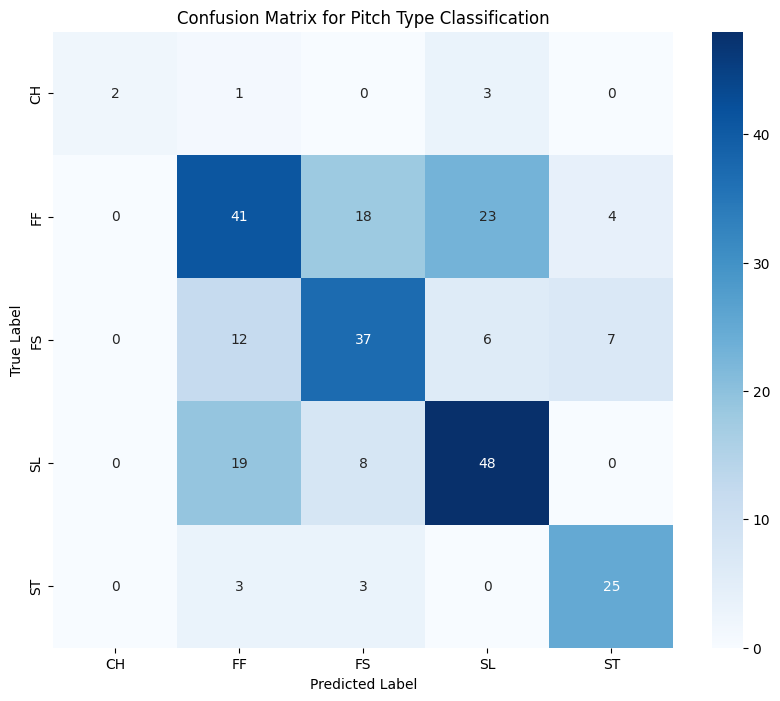


End of Model Evaluation.


In [41]:
# Define a placeholder for log_step if it's not defined globally
def log_step(message):
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] {message}")

# 1. Encode Labels
# For pitch_type (y1)
le_pitch_type = LabelEncoder()
y1_encoded = le_pitch_type.fit_transform(y1_data)
print(f"\nEncoded Pitch Types (first 5): {y1_encoded[:5]}")
print(f"Pitch Type Classes: {le_pitch_type.classes_}")

# For description (y2)
le_description = LabelEncoder()
y2_encoded = le_description.fit_transform(y2_data)
print(f"Encoded Descriptions (first 5): {y2_encoded[:5]}")
print(f"Description Classes: {le_description.classes_}")

# Choose which target to model (e.g., pitch_type first)
target_labels = y1_encoded # Or y2_encoded for description classification
target_encoder = le_pitch_type # Or le_description

log_step("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_features, target_labels, test_size=0.2, random_state=42, stratify=target_labels
)
log_step("Data split complete.")

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Check class distribution in training set before oversampling
print("\nClass distribution in y_train before oversampling:")
for label, count in Counter(y_train).items():
    print(f"{target_encoder.inverse_transform([label])[0]}: {count}")

# 2. Build and Train the Pipeline
log_step("Building and training the Random Forest Classifier pipeline with RandomOverSampler...")
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

pipeline.fit(X_train, y_train)
log_step("Model training complete.")

# 3. Make Predictions
log_step("Making predictions on the test set...")
y_pred = pipeline.predict(X_test)
log_step("Predictions complete.")

# 4. Evaluate the Model
print("\n" + "="*50)
print("Model Evaluation Results:")
print("="*50)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_encoder.classes_,
    yticklabels=target_encoder.classes_
)
plt.title(f'Confusion Matrix for {("Pitch Type" if target_encoder == le_pitch_type else "Description")} Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\n" + "="*50)
print("End of Model Evaluation.")
print("="*50)